# Install Dependencies

In [1]:
!pip install pinecone-client[grpc]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
google-cloud-aiplatform 0.6.0a1 requires google-api-core[grpc]<2.0.0dev,>=1.22.2, but you have google-api-core 2.11.1 which is incompatible.
google-cloud-automl 1.0.1 requires google-api-core[grpc]<2.0.0dev,>=1.14.0, but you have google-api-cor

# Import 

In [2]:
import json
import os
import re
import pinecone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from scipy import stats
from tqdm.auto import tqdm

from kaggle_secrets import UserSecretsClient


/opt/conda/lib/python3.10/site-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load the Data

In [3]:
if os.environ.get('KAGGLE_URL_BASE',''):
    RESULTS_DIR = '/kaggle/input/eps-training-results/results/'
else:
    RESULTS_DIR = 'eps-training-results/results/'
# List all results
result_files = os.listdir(RESULTS_DIR)
results = {}
for fname in tqdm(result_files):
    # Load result batch
    with open(os.path.join(RESULTS_DIR, fname), 'r') as f:
        batch_results = json.load(f)
    batch_id = int(re.findall(r'_(\d+)\.json', fname)[0])
    result_id = batch_id * 100
    # Convert into columnar format
    for result in batch_results:
        results[result_id] = {}
        results[result_id]['em'] = result['em']
        for i, instruction in enumerate(result['instructions']):
            results[result_id][f'ins{i}_id'] = int(instruction['id'])
            results[result_id][f'ins{i}_sim'] = float(instruction['similarity'])
        result_id += 1

results = pd.DataFrame.from_dict(results, orient='index')
results = results.sort_index()


  0%|          | 0/1384 [00:00<?, ?it/s]

# Get Instructions

## Initialize Database Connection

In [4]:
user_secrets = UserSecretsClient()
PINECONE_API_KEY = user_secrets.get_secret('PINECONE_API_KEY')
PINECONE_ENV = user_secrets.get_secret('PINECONE_ENVIRONMENT')
INDEX_NAME = 'plans'
pinecone.init(
        api_key=PINECONE_API_KEY,
        environment=PINECONE_ENV
    )
index = pinecone.GRPCIndex(INDEX_NAME)


## Fetch Instructions

In [5]:
total_vector_count = index.describe_index_stats()['total_vector_count']
chunk_size = 1000
instructions = {}
for chunk_start in tqdm(range(0, total_vector_count, chunk_size)):
    chunk_end = min(chunk_start + 1000, total_vector_count)
    idx = [str(i) for i in range(chunk_start, chunk_end)]
    vectors = index.fetch(idx)['vectors']
    for entry_id, entry in vectors.items():
        instruction = {}
        for field in ['question', 'plan', 'score']:
            instruction[field] = entry['metadata'][field]
        instructions[int(entry_id)] = instruction

instructions = pd.DataFrame.from_dict(instructions, orient='index')
instructions = instructions.sort_index()


  0%|          | 0/78 [00:00<?, ?it/s]

# Explore data

## Instructions

In [6]:
instructions.head()

question  \
0  Which European capital city lies on the River ...   
1       Who directed the Godfather trilogy of films?   
2                 An archipelago is a group of what?   
3  In which year was live television coverage of ...   
4  Imagine it's Friday the 13th, what day of the ...   

                                                plan  score  
0  Plan: Search for more information about the Ri...   43.0  
1  Plan: Search for more information about the Go...   24.0  
2  Plan: Search for more information about archip...   17.0  
3  Plan: Search for more information about the hi...   15.0  
4  Plan: Research the date of the 1st\n#E1 = Wiki...   20.0

In [7]:
instructions.describe()

score
count  77215.000000
mean       3.996128
std        5.993244
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max      120.000000

## Results

In [8]:
results.head()

em  ins0_id  ins0_sim  ins1_id  ins1_sim  ins2_id  ins2_sim
0   True     1199  0.279815      256  0.298869     1196  0.338990
1   True      313  0.358617      417  0.378092     1049  0.409587
2  False     1914  0.390512     1726  0.365760      710  0.363141
3   True      116  0.236553      663  0.627054       66  0.237431
4   True     1196  0.297679       48  0.319736     1148  0.338284

In [9]:
results.describe()

ins0_id       ins0_sim        ins1_id       ins1_sim  \
count  138384.000000  138384.000000  138384.000000  138384.000000   
mean    16229.779180       0.462849   16275.815853       0.462839   
std     15252.220181       0.110298   15275.926230       0.110549   
min         0.000000       0.143001       0.000000       0.154064   
25%      4295.000000       0.392763    4310.750000       0.392413   
50%     11452.000000       0.446194   11433.000000       0.445844   
75%     23645.000000       0.513275   23665.000000       0.513228   
max     76949.000000       1.000000   77070.000000       1.000000   

             ins2_id       ins2_sim  
count  138384.000000  138384.000000  
mean    16360.066973       0.462911  
std     15300.414071       0.110237  
min         0.000000       0.147847  
25%      4379.000000       0.392930  
50%     11506.000000       0.445656  
75%     23841.000000       0.513253  
max     76899.000000       1.000000

In [10]:
results.em.mean()

0.5572609550237022

# Visualise Data

## Set Plotting Style

In [11]:
plt.style.use('ggplot')


## Visualize Instruction Scores

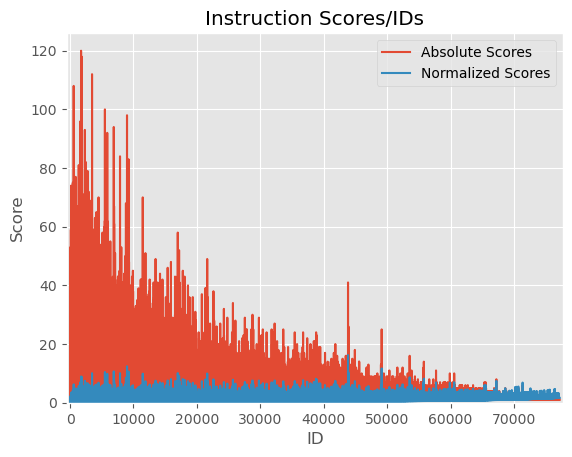

In [12]:
# Normalize scores against log(instruction_id + 1)
log_index = np.log(instructions.index + 1)
lr = stats.linregress(log_index, instructions.score)
log_curve = (lr.slope * log_index + lr.intercept)
normalized_scores = instructions.score / log_curve
# Plot Absolute Scores
plt.plot(instructions.score, label="Absolute Scores")
# Plot Normalized Scores
plt.plot(normalized_scores, label="Normalized Scores")
# Add title and labels
plt.title("Instruction Scores/IDs")
plt.xlabel("ID")
plt.ylabel("Score")
# Set plot limits
plt.xlim(-500, instructions.index.max() + 500)
plt.ylim(0, instructions.score.max() * 1.05)
# Draw legend
plt.legend()
# Show plot
plt.show()


## Visualise Exact Match

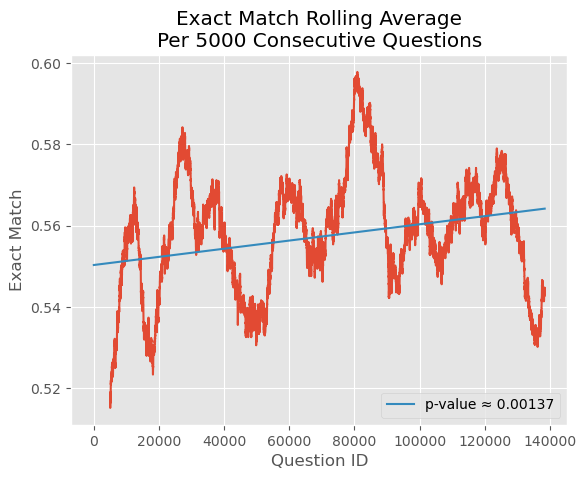

In [13]:
# Calculate rolling average
window_size = 5000
rolling_avg = results.em.rolling(window_size).mean()
# Fit a regression line
lr = stats.linregress(results.index, results.em, alternative='greater')
regression_line = lr.slope * results.index + lr.intercept
# Plot rolling average
plt.plot(rolling_avg)
# Plot regression line
plt.plot(regression_line, label=f"p-value ≈ {np.round(lr.pvalue, 5)}")
# Add title and labels
title = "Exact Match Rolling Average\n"
title += f"Per {window_size} Consecutive Questions"
plt.title(title)
plt.xlabel("Question ID")
plt.ylabel("Exact Match")
# Draw legend
plt.legend(loc='lower right')
# Show plot
plt.show()


# Analyze Data

## Get Normalized Instruction Scores

In [14]:
get_score = lambda iid: normalized_scores[iid]
for col in list(results):
    if 'id' not in col:
        continue
    results[f"{col[:-2]}nis"] = results[col].apply(get_score)


## Compute Normalized Instruction Scores * Similarity

In [15]:
for i in range(3):
    ins_scores = results[f'ins{i}_nis']
    ins_sims = results[f'ins{i}_sim']
    results[f'ins{i}_nis*sim'] = ins_scores * ins_sims


## Define Analyzer Function

In [16]:
def analyze_instructions(results, score_type, func):
    # Select scores
    match score_type:
        case 'NIS':
            scores = results[[col for col in list(results)
                              if col[-4:] == '_nis']]
        case'SIM':
            scores = results[[col for col in list(results)
                              if col[-4:] == '_sim']]
            scores = scores.applymap(lambda s: s if s < 1.0 else 1.0)
        case 'NIS*SIM':
            scores = results[[col for col in list(results)
                              if col[-4:] == '*sim']]
        case _:
            return
    # Apply function and draw scatterplot
    func_scores = scores.apply(func, axis=1)
    color = results.em.map(lambda em:'green' if em else 'red')
    plt.scatter(results.index, func_scores, color=color, s=1, alpha=0.5)
    # Calculate and draw threshold
    lr = stats.linregress(func_scores, results.em, alternative='greater')
    threshold = round((0.5 - lr.intercept) / lr.slope, 2)
    plt.plot(results.index, [threshold] * results.shape[0], color='black')
    # Add tick for the thresgold
    locs, _ = plt.yticks()
    plt.yticks(locs.tolist() + [threshold])
    # Add title and labels
    func_name = func.__name__.capitalize() 
    plt.title(f'{func_name}({score_type})/IDs')
    plt.xlabel('Question ID')
    plt.ylabel(f'Normalized Instruction Score ({func_name})')
    # Set plot limits
    plt.xlim(-500, results.index.max() + 500)
    ylim_upper = np.ceil(func_scores.quantile(0.999))
    plt.ylim(0, ylim_upper)
    # Draw legend
    green_patch = Patch(color='green', label='True')
    red_patch = Patch(color='red', label='False')
    handles = [green_patch, red_patch]
    plt.legend(handles=handles, loc='upper right')
    # Show plot
    plt.show()
    # Calculate metrics
    fp = ((func_scores >= threshold) & (-results.em)).mean()
    fn = ((func_scores < threshold) & (results.em)).mean()
    tp = ((func_scores >= threshold) & (results.em)).mean()
    tn = ((func_scores < threshold) & (-results.em)).mean()
    acc = tp + tn
    # Print metrics
    print(f"\n{func_name}({score_type}) ~ EM")
    print(f"p-value ≈ {round(lr.pvalue, 5)}\n")
    print(f"Acc:\t{round(acc * 100, 1)}%")
    print(f"TP:\t{round(tp * 100, 1)}%")
    print(f"FP:\t{round(fp * 100, 1)}%")
    print(f"TN:\t{round(tn * 100, 1)}%")
    print(f"FN:\t{round(fn * 100, 1)}%")
    
    

## Run Analysis

### Min(NIS)

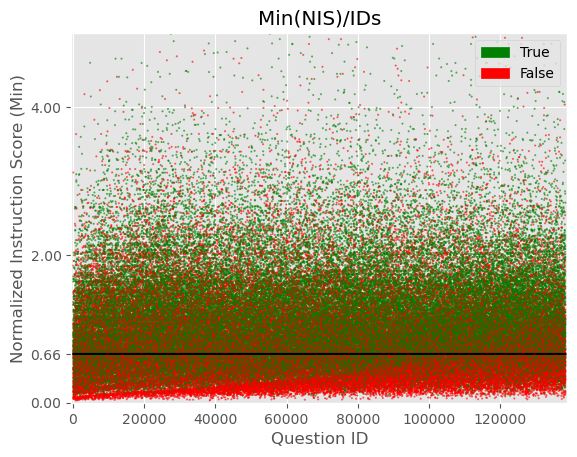


Min(NIS) ~ EM
p-value ≈ 0.0

Acc:	63.0%
TP:	41.9%
FP:	23.2%
TN:	21.1%
FN:	13.9%


In [17]:
analyze_instructions(results, 'NIS', min)

### Max(NIS)

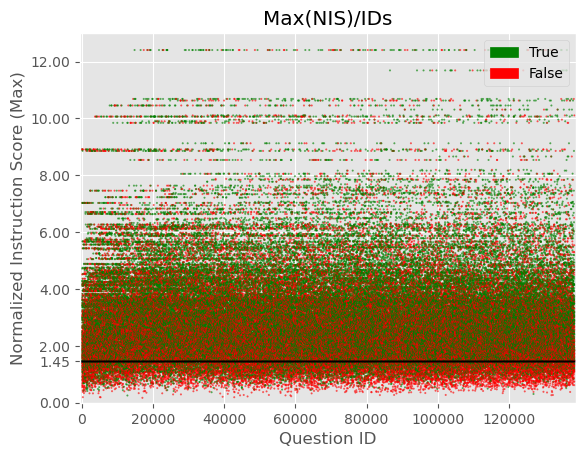


Max(NIS) ~ EM
p-value ≈ 0.0

Acc:	58.4%
TP:	51.3%
FP:	37.2%
TN:	7.1%
FN:	4.5%


In [18]:
analyze_instructions(results, 'NIS', max)

### Sum(NIS)

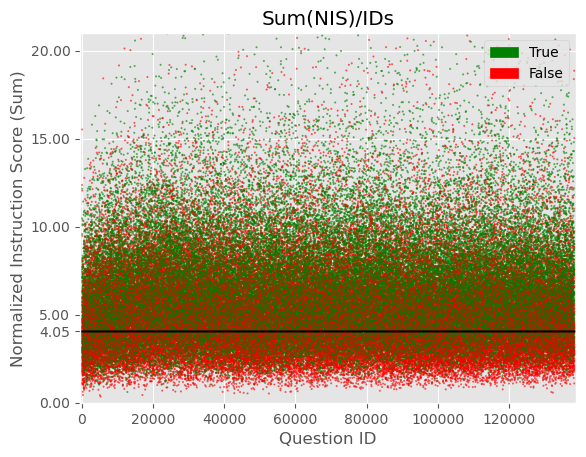


Sum(NIS) ~ EM
p-value ≈ 0.0

Acc:	60.7%
TP:	44.2%
FP:	27.8%
TN:	16.5%
FN:	11.5%


In [19]:
analyze_instructions(results, 'NIS', sum)

### Min(NIS*SIM)

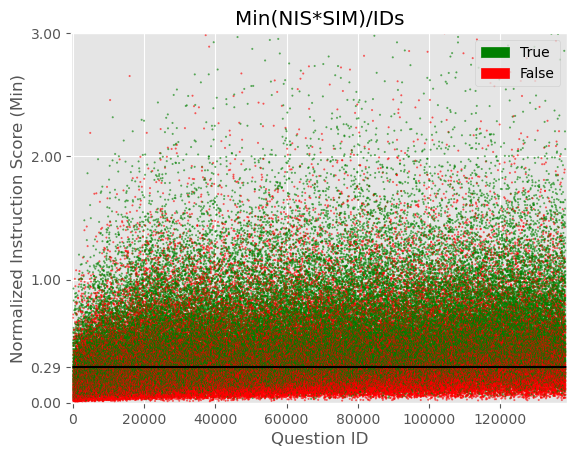


Min(NIS*SIM) ~ EM
p-value ≈ 0.0

Acc:	62.7%
TP:	41.4%
FP:	23.0%
TN:	21.3%
FN:	14.3%


In [20]:
analyze_instructions(results, 'NIS*SIM', min)

### Max(NIS * SIM)

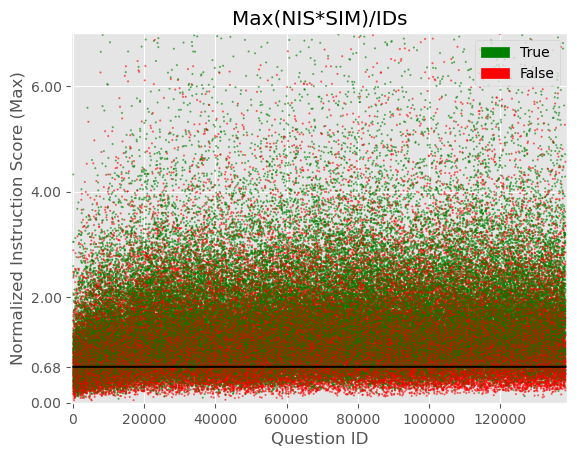


Max(NIS*SIM) ~ EM
p-value ≈ 0.0

Acc:	58.7%
TP:	49.3%
FP:	34.8%
TN:	9.4%
FN:	6.4%


In [21]:
analyze_instructions(results, 'NIS*SIM', max)

### Sum(NIS * SIM)

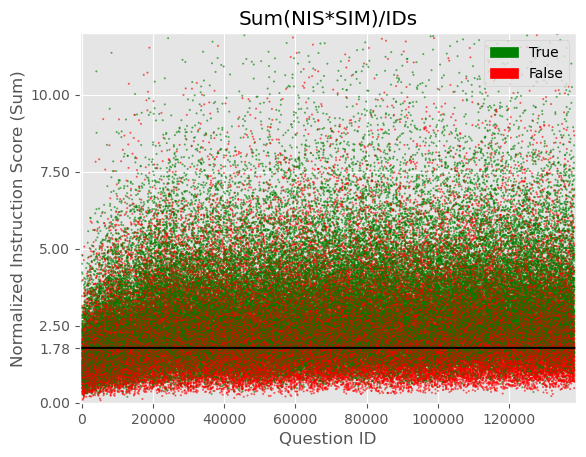


Sum(NIS*SIM) ~ EM
p-value ≈ 0.0

Acc:	60.7%
TP:	43.6%
FP:	27.2%
TN:	17.1%
FN:	12.2%


In [22]:
analyze_instructions(results, 'NIS*SIM', sum)

### Min(SIM)

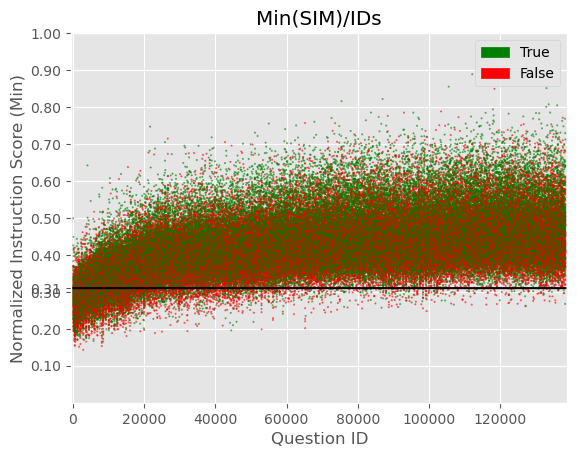


Min(SIM) ~ EM
p-value ≈ 0.0

Acc:	56.2%
TP:	52.8%
FP:	40.8%
TN:	3.4%
FN:	3.0%


In [23]:
analyze_instructions(results, 'SIM', min)

### Max(SIM)

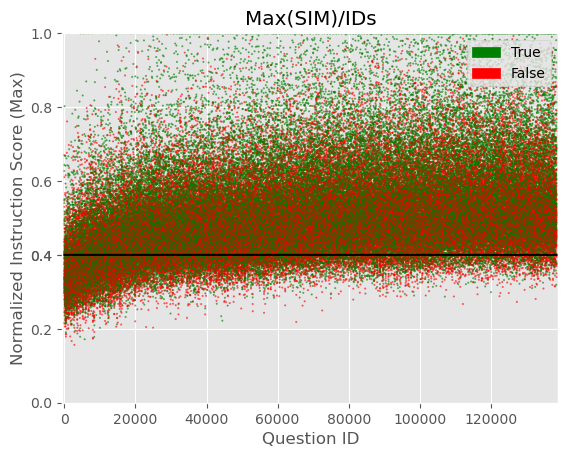


Max(SIM) ~ EM
p-value ≈ 0.0

Acc:	55.8%
TP:	48.0%
FP:	36.4%
TN:	7.9%
FN:	7.7%


In [24]:
analyze_instructions(results, 'SIM', max)

### Sum(SIM)

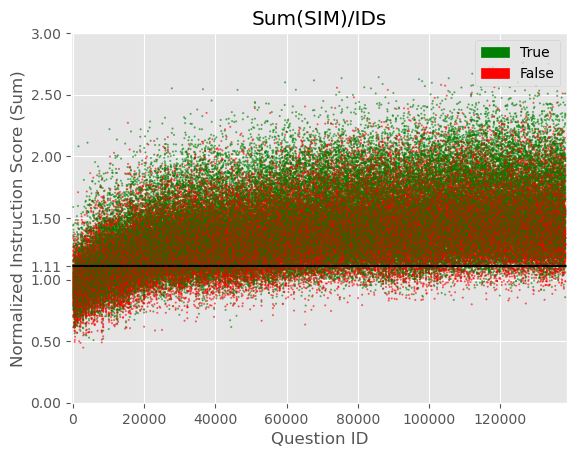


Sum(SIM) ~ EM
p-value ≈ 0.0

Acc:	56.2%
TP:	49.1%
FP:	37.2%
TN:	7.1%
FN:	6.7%


In [25]:
analyze_instructions(results, 'SIM', sum)